In [83]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import matplotlib.patches as mpatches
import demo_func
import importlib as imp
imp.reload(demo_func)
from demo_func import DemoData, hierarchy_pos

## Generating data

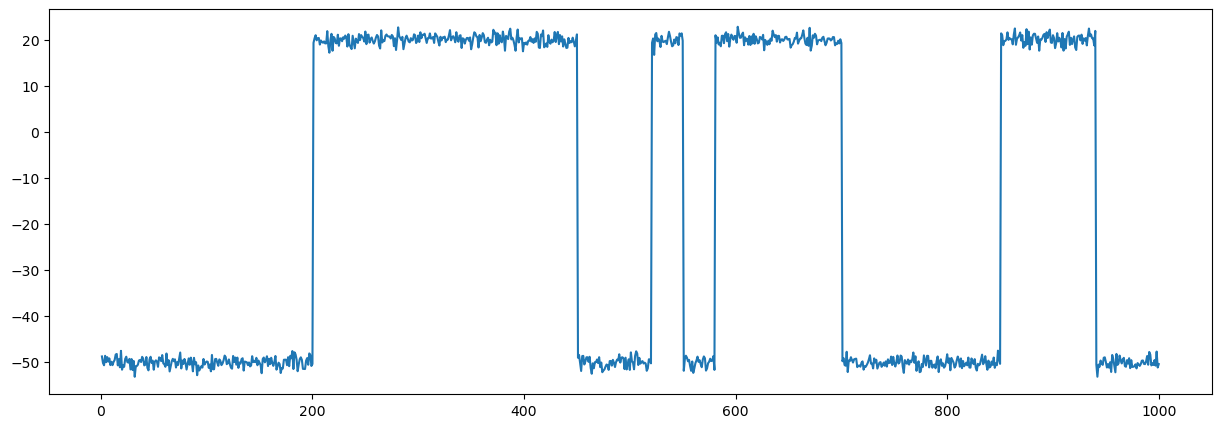

In [84]:
signals_to_generate = 100
network_cluster_count = 12
x_plot_labels = np.linspace(1, 1000, 1000)

demo = DemoData(no_signals=signals_to_generate, seed=833142, no_network_clusters = network_cluster_count)
signals = demo.generate_raw_data()
fig = plt.figure(figsize=(15,5))
ax =fig.subplots()
ax.plot(x_plot_labels, signals[0,])
plt.show()

In [85]:
impairments = {
            "Suckout" : (20, "green", np.arange(300,370), 0.5 * (np.abs(np.arange(-35, 35)) - 35)),
            "Wave" : (12, "orange", np.arange(580,700), 3*np.sin(np.arange(120)/5)),
        }

tilt_x = np.arange(1000)
tilt_y = np.zeros(1000,)
tilt_y[demo.ideal_signal > 0] = -tilt_x[demo.ideal_signal > 0] * 0.02
impairments["Tilt"] = (19, "red", tilt_x, tilt_y)

graph, impaired_signals, network_clusters = demo.generate_impaired_graph(impairments=impairments)

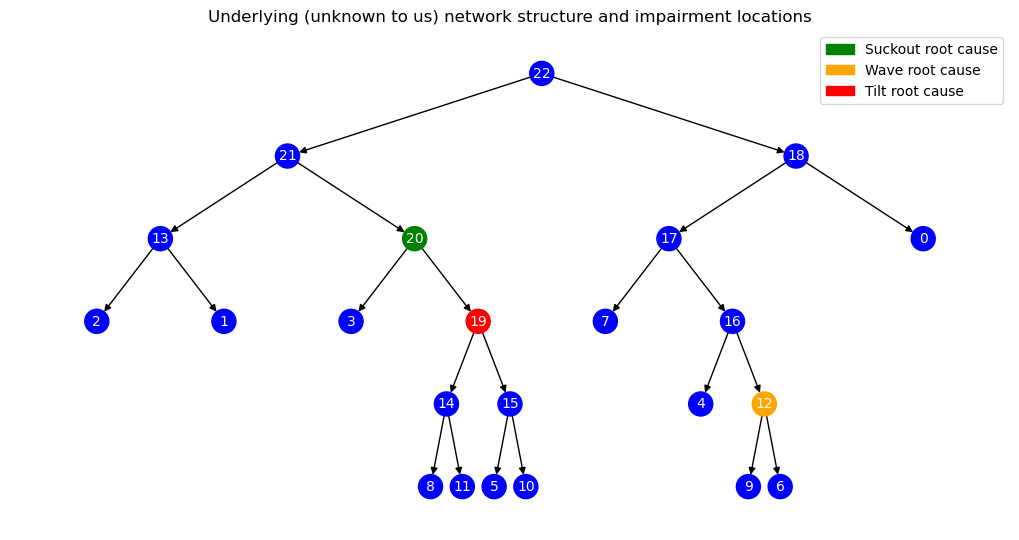

In [86]:
root_node_id = network_cluster_count * 2 - 2
pos = hierarchy_pos(graph,root=root_node_id)    
handles=[mpatches.Patch(color=color, label=f"{name} root cause") for name, (_, color, _, _) in impairments.items()]
fig = plt.figure(figsize=(10,5))
colors = list(nx.get_node_attributes(graph,'color').values())
nx.draw(graph, pos = pos, with_labels=True, node_color = colors, font_size=10, font_color="white")
plt.legend(handles=handles)
plt.title("Underlying (unknown to us) network structure and impairment locations")
plt.show()

In [87]:
samples = {
    'Healthy signal': impaired_signals[network_clusters == 2,:][0],
    'Suckout impaired signal': impaired_signals[network_clusters == 3,:][0],
    'Tilt-suckout impaired signal': impaired_signals[network_clusters == 8,:][0],
    'Wave impaired signal': impaired_signals[network_clusters == 9,:][0],
}

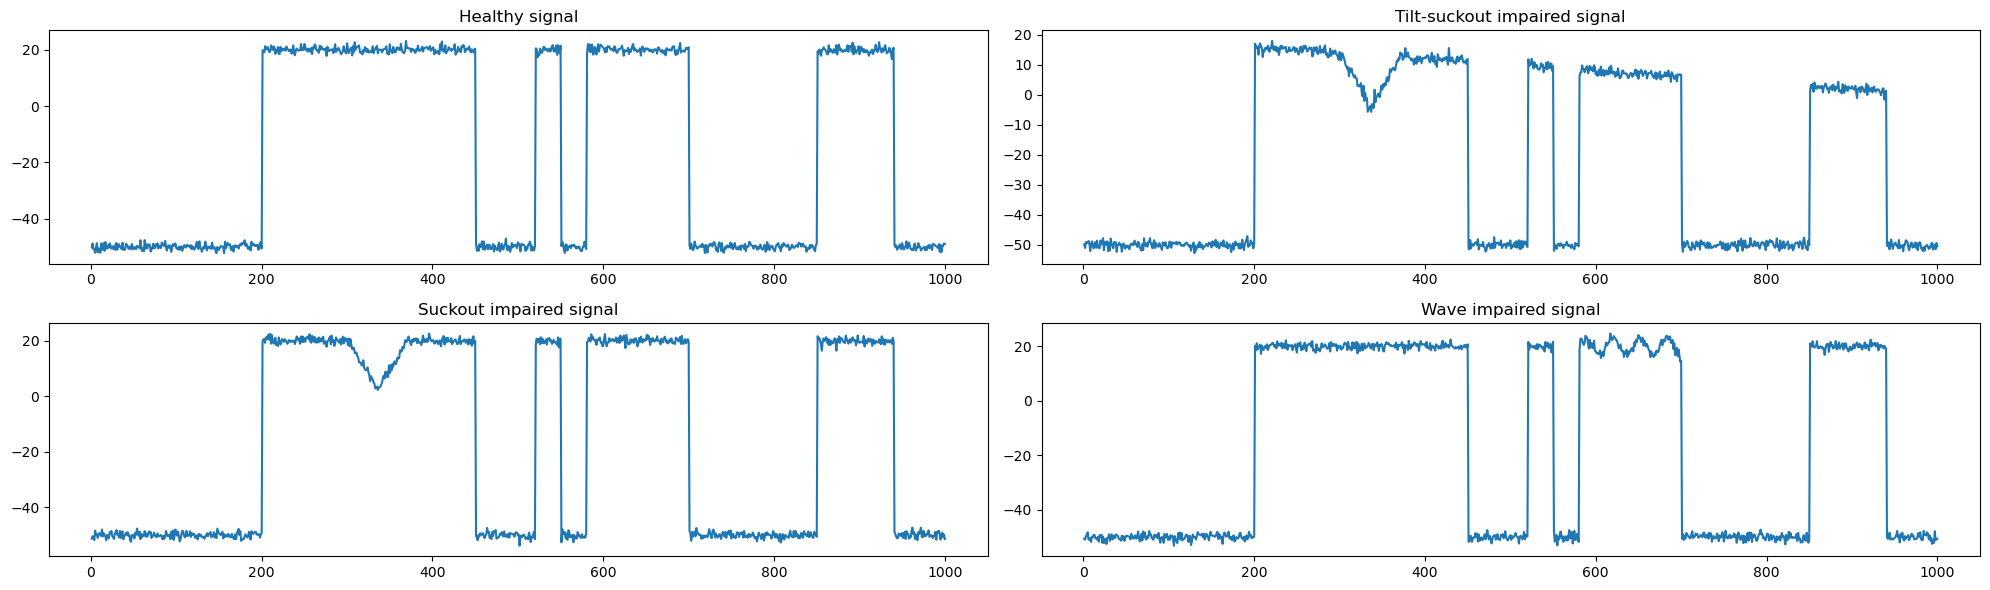

In [88]:
fig = plt.figure(figsize=(20,6))
ax =fig.subplots(2,2)
for i, (title, signal) in enumerate(samples.items()):
    row = i % 2
    col = int(i / 2)
    ax[row, col].plot(np.linspace(1, 1000, 1000), signal)
    ax[row, col].set_title(title)
plt.tight_layout()
plt.show()


## Obtaining wavelet coefficients and performing clustering

In [89]:
import scipy.cluster.hierarchy as sch

In [90]:
sparse_matrix = demo.get_sparse_wavelet_matrix(impaired_signals)
print(f"Number of non_zero entries: {sparse_matrix.count_nonzero()}")

Number of non_zero entries: 4637


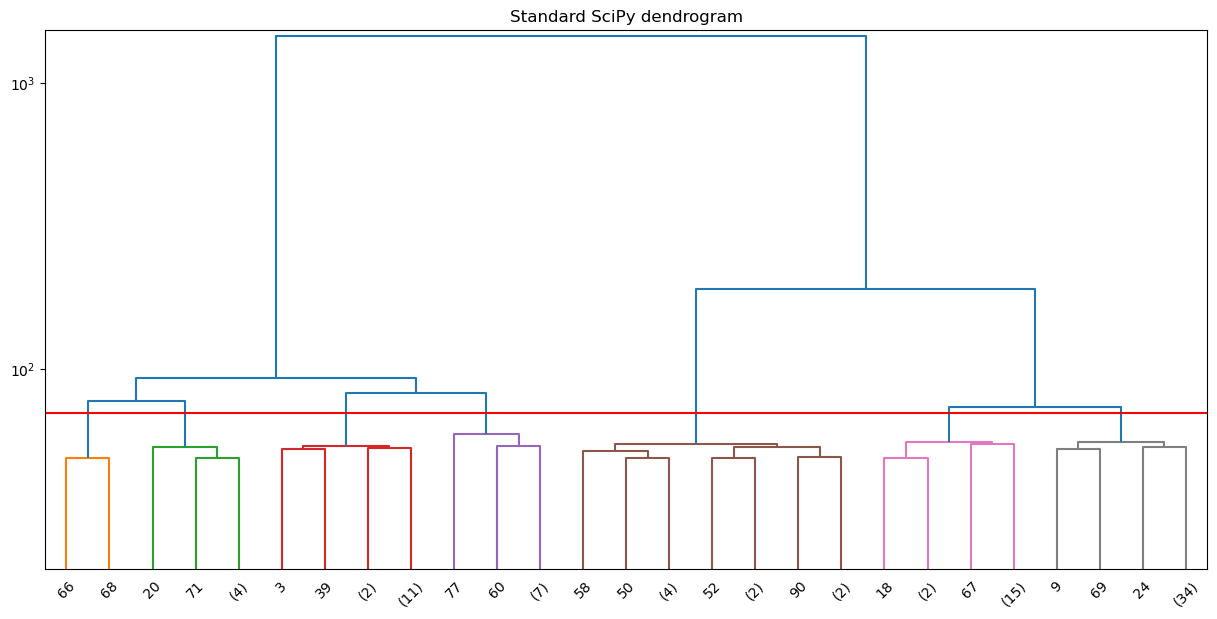

In [91]:
dists = demo.get_adjacency_matrix(sparse_matrix)
model = sch.linkage(dists, method='average')
threshold = 70
figure = plt.figure(figsize=(15,7))
ax = figure.subplots()
sch.dendrogram(model, ax=ax, truncate_mode='level', p=4, color_threshold=threshold)
plt.yscale('symlog')
plt.ylim(20)
plt.axhline(threshold, color='red')
plt.title("Standard SciPy dendrogram")
plt.show()

In [92]:
recovered_clusters = sch.fcluster(model, threshold, criterion='distance')
recovered_clusterset = set(recovered_clusters)

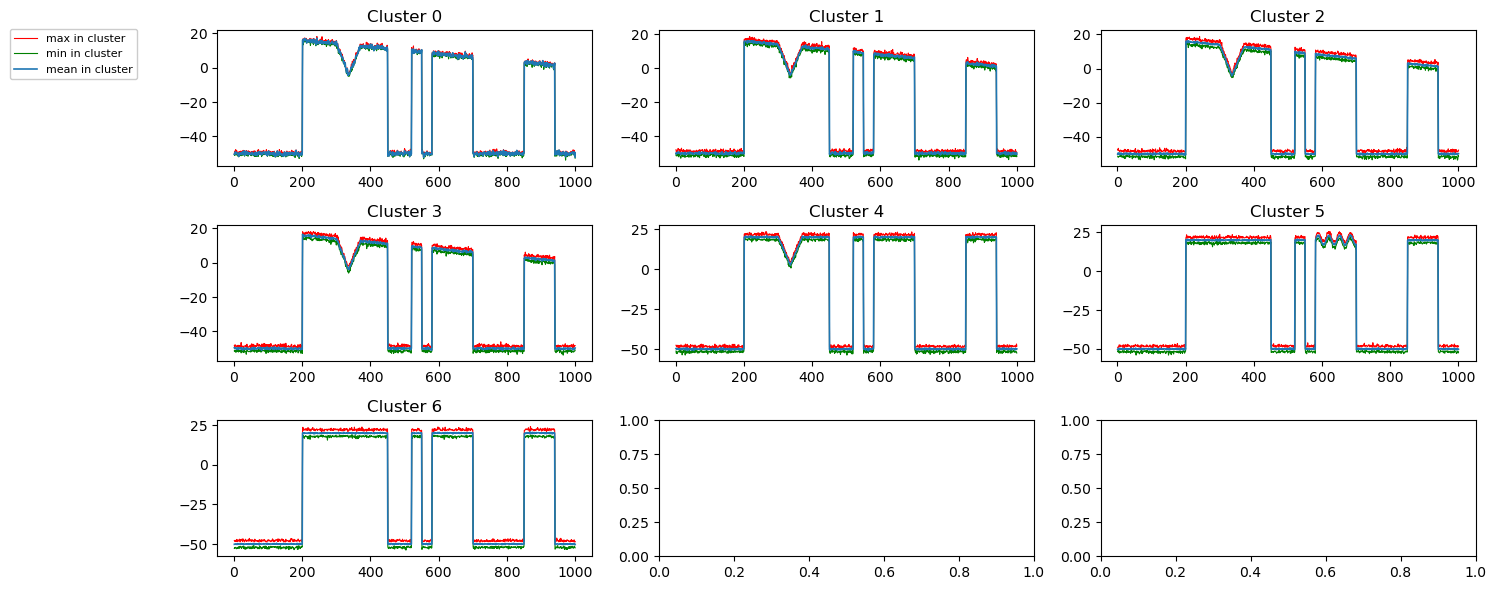

In [93]:
no_rec_clusters = len(recovered_clusterset)
no_cols = 3
no_rows = int(no_rec_clusters / no_cols) + no_rec_clusters % no_cols

fig = plt.figure(figsize=(5 * no_rows, 2 * no_cols))
ax = fig.subplots(no_rows, no_cols)

for i, cluster in enumerate(recovered_clusterset):
    row = int(i / no_cols)
    col = i % no_cols
    cluster_signals = impaired_signals[recovered_clusters == cluster,:]
    avg = np.mean(cluster_signals, axis=0)
    mx = np.max(cluster_signals, axis=0)
    mn = np.min(cluster_signals, axis=0)
    ax[row,col].plot(x_plot_labels, mx, color='red', linewidth=0.8, label='max in cluster')
    ax[row,col].plot(x_plot_labels, mn, color='green', linewidth=0.8, label='min in cluster')
    ax[row,col].plot(x_plot_labels, avg, linewidth=1.2, label='mean in cluster')
    ax[row,col].set_title(f"Cluster {i}")
ax[0,0].legend(loc='upper right', fontsize=8, bbox_to_anchor=(-0.2, 1.05), facecolor='white', framealpha=1)
plt.tight_layout()
plt.show()

## A cleaner SciPy dendrogram

In [94]:
import os, sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))

import idendro
import importlib as imp

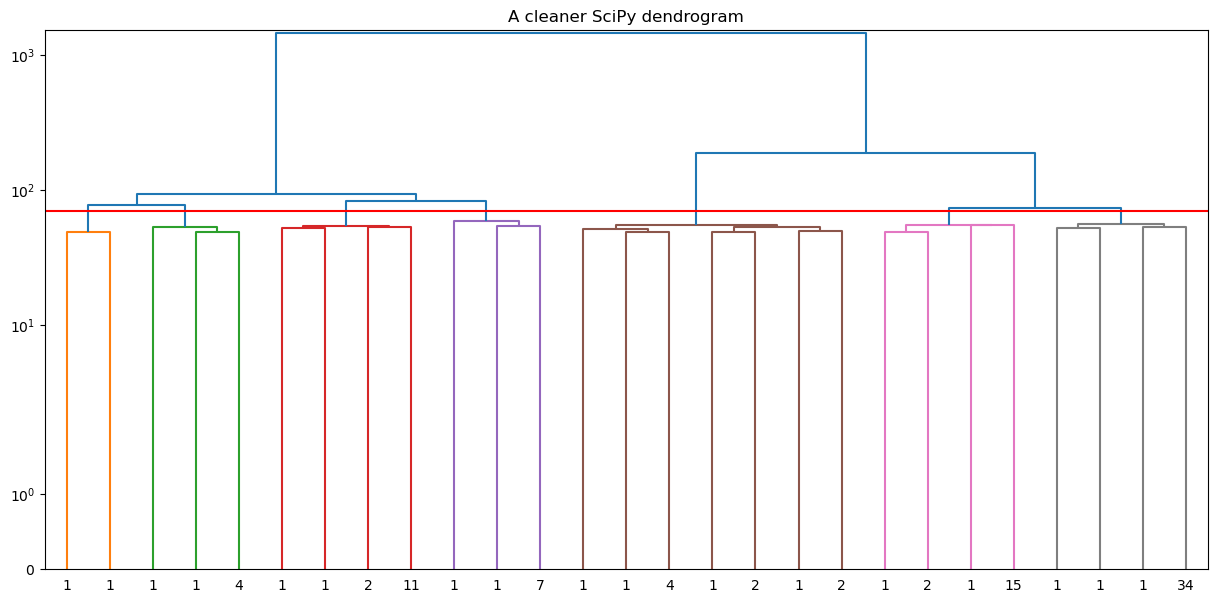

In [95]:
figure = plt.figure(figsize=(15,7))
ax = figure.subplots()
imp.reload(idendro)
dd = idendro.Idendro(model, recovered_clusters, threshold)
sch.dendrogram(
    Z=model, 
    ax=ax, 
    truncate_mode='level', p=4, 
    leaf_label_func= dd.get_counts(),
    color_threshold=threshold,
    orientation='top')
plt.yscale('symlog')
#plt.ylim(top=20)
plt.axhline(threshold, color='red')
plt.title("A cleaner SciPy dendrogram")
plt.xticks(rotation=0)
plt.show()

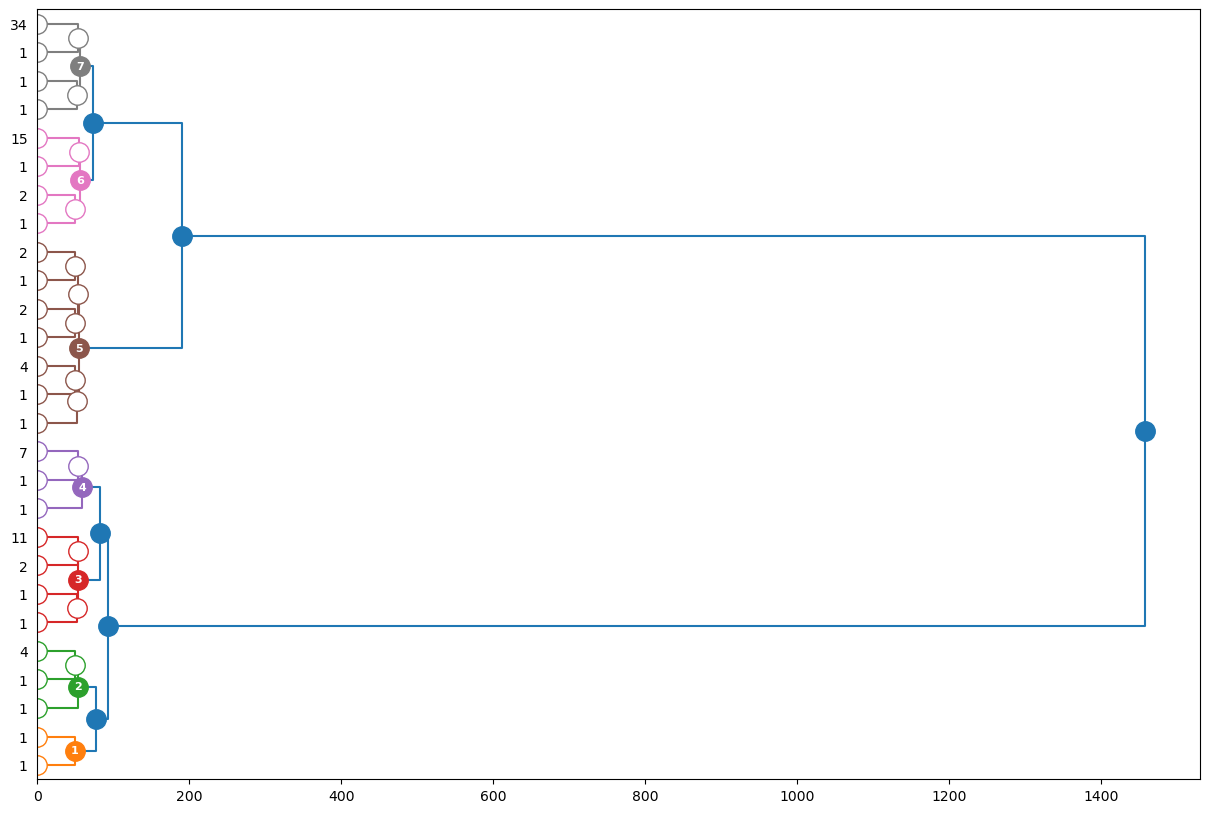

In [96]:
dd = idendro.Idendro(model, recovered_clusters, threshold, dendrogram_kwargs={'leaf_label_func': dd.get_counts()})
fig = plt.figure(figsize=(15,10))
ax = fig.subplots()
dgram = dd.to_scipy(
    orientation='right', 
    show_points = True,
    ax=ax
)
dgram
#ax.set_yscale('symlog')

In [99]:
imp.reload(idendro)

dd = idendro.Idendro(model, recovered_clusters, threshold)
dd.dendrogram_kwargs.update({'leaf_label_func': dd.get_counts()})

def hovertext_func(point):
    _, tree = dd.get_tree()

    count = tree[point['id']].get_count()
    nodes = tree[point['id']].pre_order(lambda x: x.get_id() if x.is_leaf() else None)  
    sds = impaired_signals[nodes, :].std(axis=0)       
    return {
        "Number of items": count,
        "Type": point['type'],
        "Max st dev observed": sds.max().round(2)
    }


pltd = dd.to_plotly(
    orientation='left', 
    show_points = True, 
    width=1000,
    height=800,
    point_trace_kwargs = {'textfont_color': 'blue', 'marker': {'size': 10}},
    point_hover_func= hovertext_func
)
pltd.update_xaxes(type='log', range=(-1, 3.3))
pltd


In [100]:
imp.reload(idendro)

dd = idendro.Idendro(model, recovered_clusters, threshold)
dd.dendrogram_kwargs.update({'leaf_label_func': dd.show_only_cluster_labels()})

def hovertext_func(point):
    _, tree = dd.get_tree()

    count = tree[point['id']].get_count()
    nodes = tree[point['id']].pre_order(lambda x: x.get_id() if x.is_leaf() else None)  
    sds = impaired_signals[nodes, :].std(axis=0)       
    return {
        "Number of items": count,
        "Type": point['type'],
        "Max st dev observed": sds.max().round(2)
    }    

pltd = dd.to_altair(
    orientation='right', 
    show_points = True, 
    point_hover_func= hovertext_func
).properties(width=600, height=800)
pltd.layer[0].encoding.x.scale['type'] = 'symlog'
pltd.layer[0].encoding.x.scale['constant'] = 50
#print(pltd.to_json())
pltd


alt.LayerChart(...)

In [102]:
from pprint import pprint


imp.reload(idendro)

dd = idendro.Idendro(model, recovered_clusters, threshold)
dd.dendrogram_kwargs.update({'leaf_label_func': dd.show_only_cluster_labels()})

d_data = dd.to_json(
    show_nodes = True, 
    node_hover_func= hovertext_func
)

pprint(d_data)

('{"axis_labels": [{"x": 5.0, "label": "Cluster 1 (2 data points)", '
 '"labelsize": 8.0}, {"x": 15.0, "label": " ", "labelsize": 8.0}, {"x": 25.0, '
 '"label": "Cluster 2 (6 data points)", "labelsize": 8.0}, {"x": 35.0, '
 '"label": " ", "labelsize": 8.0}, {"x": 45.0, "label": " ", "labelsize": '
 '8.0}, {"x": 55.0, "label": "Cluster 3 (15 data points)", "labelsize": 8.0}, '
 '{"x": 65.0, "label": " ", "labelsize": 8.0}, {"x": 75.0, "label": " ", '
 '"labelsize": 8.0}, {"x": 85.0, "label": " ", "labelsize": 8.0}, {"x": 95.0, '
 '"label": "Cluster 4 (9 data points)", "labelsize": 8.0}, {"x": 105.0, '
 '"label": " ", "labelsize": 8.0}, {"x": 115.0, "label": " ", "labelsize": '
 '8.0}, {"x": 125.0, "label": "Cluster 5 (12 data points)", "labelsize": 8.0}, '
 '{"x": 135.0, "label": " ", "labelsize": 8.0}, {"x": 145.0, "label": " ", '
 '"labelsize": 8.0}, {"x": 155.0, "label": " ", "labelsize": 8.0}, {"x": '
 '165.0, "label": " ", "labelsize": 8.0}, {"x": 175.0, "label": " ", '
 '"labelsiz